In [124]:
import os
from fastbook import *
from fastai.vision.widgets import *

# GATHERING DATA

In [125]:
# Set API key
key = os.environ.get('AZURE_SEARCH_KEY')

In [126]:
# Specify different types of sharks in the model
shark_types = 'tiger', 'great white', 'hammerhead'

# Set path to folder which will store images
path = Path('sharks') 

# If the path doesn't already exist, create it
if not path.exists():
    path.mkdir()
    # for every shark breed, create a new folder and store 150 images from bing's image API
    for breed in shark_types:
        dest = (path/breed)
        dest.mkdir(exist_ok=True)
        data_images = search_images_bing(key, f'{breed} shark')
        download_images(dest, urls=data_images.attrgot('contentUrl'))

# PREPROCESSING THE DATA

In [127]:
## CHECK AND REMOVE CORRUPT FILES FROM THE DATA OBTAINED

# Store the paths to each image created in a variable 'fns'
fns = get_image_files(path)

# Store corrupt files in the variable 'failed'
failed = verify_images(fns)

# Remove images which failed
failed.map(Path.unlink)

(#7) [None,None,None,None,None,None,None]

In [128]:
# Create datablock
sharks_db = DataBlock(
    blocks=(ImageBlock, CategoryBlock) # types of blocks for input (images) and label (category)
    , get_items=get_image_files # recursively gets all images from path provided
    , get_y=parent_label # label of the image should be the name of its parent folder
    , splitter=RandomSplitter(valid_pct=0.3, seed=27) # randomly split data into training (70%) and validation (30%) sets
    , item_tfms=Resize(128) # resize images to be of same size (128 x 128) -- FLEXIBLE
)

In [129]:
# Create dataloaders based on datablock created and path given (tells which folder to extract the images from)
dls = sharks_db.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


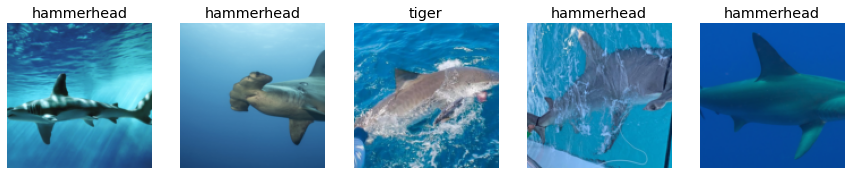

In [130]:
# Show 5 images from validation set
dls.valid.show_batch(max_n=5, nrows=1)

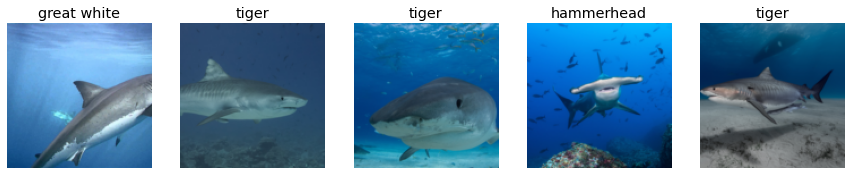

In [131]:
# Show 5 images from training set
dls.train.show_batch(max_n=5, nrows=1)

In [132]:
# Create new datablock using a new item_tfms method and random data augmentation applied in batches
sharks_db2 = sharks_db.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5) # crop a random portion of the image and resize it to 224 x 224
    , batch_tfms=aug_transforms() # put images into batches and, for each batch, apply a random data augmentation transformation
)

# Create new dataloaders object based on new datablock
dls2 = sharks_db2.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


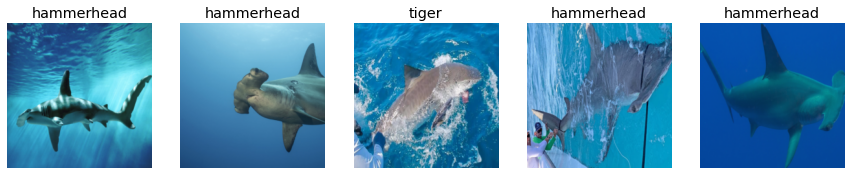

In [133]:
# Show 5 images from new validation set
dls2.valid.show_batch(max_n=5, nrows=1)

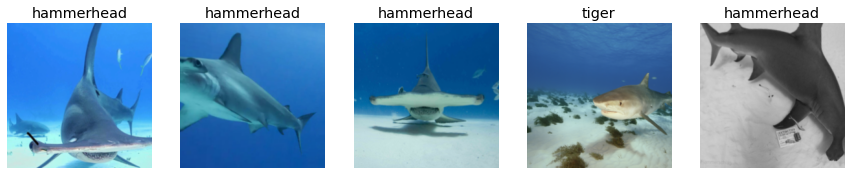

In [134]:
# Show 5 images from new training set
dls2.train.show_batch(max_n=5, nrows=1)

#### RANDOM RESIZED CROP SEEMS TO WORK BETTER -- USE SECOND METHOD

# TRAIN MODEL

In [135]:
# Create learner object using the random resized crop data with batch transforms. 
# Use 18 layers of the pre-trained model 'resnet'
learn = vision_learner(dls2, resnet18, metrics=error_rate)
learn.fine_tune(5) # Train data using 5 epochs

epoch,train_loss,valid_loss,error_rate,time
0,1.654998,0.633776,0.251969,01:59


epoch,train_loss,valid_loss,error_rate,time
0,0.902806,0.543786,0.236220,02:12
1,0.749656,0.511094,0.173228,02:11
2,0.630295,0.526952,0.165354,11:25
3,0.522037,0.474220,0.157480,02:06
4,0.452421,0.456825,0.157480,02:06


# EVALUATE MODEL

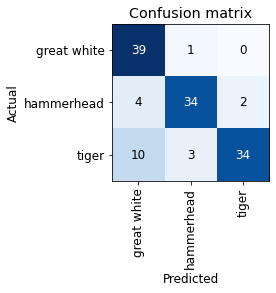

In [136]:
# Create confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### The initial model classified 107 images correctly and 20 incorrectly:
- Total model accuracy = 107/127 = 84.25%
- Great white accuracy = 39/40 = 97.50%
- Hammerhead accuracy = 34/40 = 85.00%
- Tiger accuracy = 34/47 = 72.34% -- POTENTIAL FOR SOME LABELS TO BE WRONG, LABELLING 'GREAT WHITE' WHEN IT SHOULD BE 'TIGER'

# DATA CLEANING / MODEL IMPROVEMENT

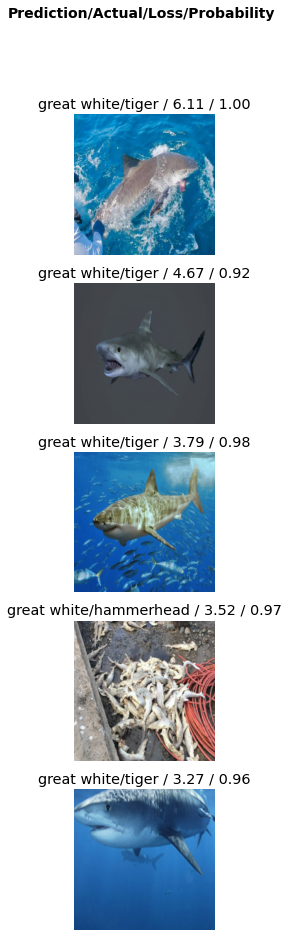

In [137]:
# Show the 5 images with the higher losses
interp.plot_top_losses(5, nrows=5)

In [138]:
cleaner = ImageClassifierCleaner(learn)
cleaner
# Update status of unwanted images to '<Delete>' or change label of incorrectly labeled files

In [144]:
## RUN CODE TO DELETE IMAGE OR CHANGE LABEL ONCE PER FOLDER WHILE STATE IS UPDATED (SO 6 TIMES IN TOTAL IN THIS CASE) !!
# https://forums.fast.ai/t/imageclassifiercleaner-cleaning-multiple-folders/89330/4

# Remove images to be deleted
# for idx in cleaner.delete(): cleaner.fns[idx].unlink() # -- RUN THIS TO DELETE IMAGE

# Switch labels of wrongly labeled data
# Create 'moved' folder in each category of sharks folder
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat/'moved') # -- RUN THIS TO CHANGE LABEL
# Manually move images from 'moved' folder to the category - https://forums.fast.ai/t/several-unwanted-behaviors-from-imageclassifiercleaner/67890/6


# TRAIN UPDATED MODEL

In [145]:
# Train new model from scratch based on cleaned data
dls_clean = sharks_db2.dataloaders(path)

learn_clean = vision_learner(dls_clean, resnet18, metrics=error_rate)
learn_clean.fine_tune(5) # Train data using 5 epochs

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


epoch,train_loss,valid_loss,error_rate,time
0,1.739768,1.569042,0.500000,01:57


epoch,train_loss,valid_loss,error_rate,time
0,1.060779,0.806399,0.274194,02:07
1,0.848146,0.486038,0.161290,02:11
2,0.659404,0.404171,0.129032,02:08
3,0.554720,0.329221,0.120968,02:06
4,0.472882,0.301211,0.112903,02:10


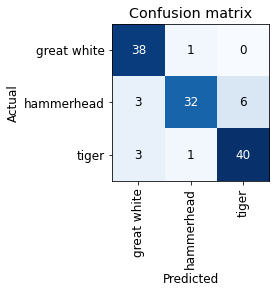

In [146]:
# Create confusion matrix
interp_clean = ClassificationInterpretation.from_learner(learn_clean)
interp_clean.plot_confusion_matrix()

#### The improved model classified 110 images correctly and 14 incorrectly:
                                             original vs updated
- Total model accuracy = 110/124 =            84.25% < 88.70%            -- PERFORMANCE IMPROVED [+4.45%]
- Great white accuracy = 38/39   =            97.50% > 97.44%            -- PERFORMANCE EQUALED [-0.06%]
- Hammerhead accuracy  = 32/41   =            85.00% < 78.05%            -- PERFORMANCE WORSENED [-6.95%]
- Tiger accuracy       = 40/44   =            72.34% > 90.90%            -- PERFORMANCE IMPROVED [+18.56%]

#### REASONS FOR CHANGES:
- Great white accuracy --> same number of wrongly labeled images. Performance remained equal -- NOT A CONCERN.
-----------------------------------------------------------------------------------------------------
- Hammerhead accuracy --> significantly worsened the performance, labeling 9 images incorrectly (6 as 'tiger' and 3 as 'great white' -- CONCERN!!
-----------------------------------------------------------------------------------------------------
- Tiger accuracy --> huge improvement, mainly due to deletion or relabelling of images of great whites incorrectly labeled as tiger. -- NICE!

In [147]:
# Export updated trained model as pkl file -- MODEL IS READY TO BE USED
learn_clean.export()